### Creating an Epsilon Nearest Neighbors Graph

Imports

#### Import data and basic functions

In [28]:
import glob
import random
import numpy as np
import scipy

In [21]:
SAMPLES = 10
CANCER_TYPES = 10 # How many of the types of cancer should we use
normalize = False
outliers = True
restrictSamples = False # Remove cancer types with less than SAMPLES samples

In [30]:
def generateColors(n):
    """ Generates n random colors in hex """
    
    colorList = []
    possibleValues = list(range(10))+["A","B","C","D","E","F"]
    
    for i in range(n):
        tempColor = "#"
        for j in range(6):
            tempColor+=str(possibleValues[random.randint(0,len(possibleValues)-1)])
        colorList.append(tempColor)
    
    return colorList

def toArray(fileName):
    """Converts exome data to an NP array """
    
    with open(fileName) as f:
        cancerData = f.read().split("\n")[1:-1]
        for i in range(0,len(cancerData)):
            cancerData[i] = cancerData[i].split("\t")[1:]
            cancerData[i] = list(map(int,cancerData[i]))

    cancerData = np.array(cancerData,dtype=np.float).T
    return cancerData

def normalizeRows(mat):
    """ Normalized the rows of the matrix mat """
    
    mat = deepcopy(mat)
    
    for i in range(mat.shape[0]):
        s = sum(mat[i])
        for j in range(mat.shape[1]):
            num = float(mat[i][j])/float(s)
            mat[i][j] = float(mat[i][j])
            mat[i][j]/=float(s)

            mat[i][j] = num

    return mat


In [32]:
#This sections inits all the cancer types 
alexandrovFiles = glob.glob("alexandrov_data/*.txt")

startingPositions = []
allData = np.empty((0,0),dtype=np.float)

if(CANCER_TYPES<len(alexandrovFiles)):
    alexandrovFiles = np.random.choice(alexandrovFiles,CANCER_TYPES,replace=False)
CANCER_TYPES = len(alexandrovFiles)

cancerNames = [i.split("\\")[-1].replace("_","").split("exome")[0] for i in alexandrovFiles]

colors = generateColors(len(cancerNames))
unusedCancers = []

#Combines the data from each of the samples
for i,file in enumerate(alexandrovFiles):
    cancerData = toArray(file)
    sampleRows = cancerData.shape[0]    
    selectedSamples = np.random.choice(sampleRows,min(sampleRows,SAMPLES),replace=False)

    if(sampleRows>=SAMPLES or True):
        if(len(startingPositions)==0):
            startingPositions.append(0)

        startingPositions.append(startingPositions[-1] + min(sampleRows,SAMPLES))


        cancerData = cancerData[selectedSamples]
        
        if(allData.size == 0): 
            allData = cancerData
        else:
            allData = np.append(allData,cancerData,axis=0)
    else:
        unusedCancers.append(i)

cancerNames = [i for j,i in enumerate(cancerNames) if j not in unusedCancers]
CANCER_TYPES = len(cancerNames)


if(normalize):
    allData = normalizeRows(allData)

np.savetxt("allData.csv", allData, delimiter=",")

#### Creating Nearest Neighbor graphs

In [54]:
import scipy.spatial.distance
from pynrnmf import NRNMF
import warnings

In [49]:
def createNearestNeighborEpsilon(mat,epsilon=0.3,metric="Cosine"):
    numRows = mat.shape[0]
    graph = np.zeros((numRows,numRows))
    dist = np.zeros((numRows,numRows))
    for row in range(numRows):
        for otherRow in range(numRows):
            if(otherRow==row):
                dist[row][otherRow] = 10000000
            else:
                if(metric=="Cosine"):
                    dist[row][otherRow] = scipy.spatial.distance.cosine(mat[row],mat[otherRow])
                elif(metric=="Norm"):
                    dist[row][otherRow] = np.linalg.norm(mat[row]-mat[otherRow])
        
    for row in range(numRows):
        for otherRow in range(numRows):
            if(dist[row][otherRow]<=epsilon):
                graph[row][otherRow] = 1
                graph[otherRow][row] = 1
            else:
                graph[row][otherRow] = 0
                graph[otherRow][row] = 0

    return graph

def createNearestNeighbor(mat,k=1,metric="Norm"):
    numRows = mat.shape[0]
    graph = np.zeros((numRows,numRows))
    dist = np.zeros((numRows,numRows))
    for row in range(numRows):
        for otherRow in range(numRows):
            if(otherRow==row):
                dist[row][otherRow] = 10000000
            else:
                if(metric=="Cosine"):
                    dist[row][otherRow] = 1-scipy.spatial.distance.cosine(mat[row],mat[otherRow])#np.linalg.norm(mat[row]-mat[otherRow])
                elif(metric=="Norm"):
                    dist[row][otherRow] = np.linalg.norm(mat[row]-mat[otherRow])
    
    for row in range(numRows):
        smallestNums = np.argpartition(dist[row],k)[:k]
        for i in smallestNums:
            graph[row][i] = 1
            graph[i][row] = 1

    return graph

#### Comparing Factoring Methods 

In [55]:
def factorData(k=5):
    warnings.filterwarnings("ignore")

    nn = np.array(createNearestNeighbor(allData,k=5,metric="Cosine"))
    model = NRNMF(k=k,W=nn,alpha=10000,init='random',n_inits=1, max_iter=50000, n_jobs=1)
    U, V = model.fit_transform(allData.T)
    reconstructionError = np.linalg.norm(allData.T-U.dot(V.T))
    print("Reconstruction Error with graph regularization nearest neighbor",reconstructionError)
    
    nn = np.array(createNearestNeighborEpsilon(allData,metric="Cosine"))
    model = NRNMF(k=k,W=nn,alpha=10000,init='random',n_inits=1, max_iter=50000, n_jobs=1)
    U, V = model.fit_transform(allData.T)
    reconstructionError = np.linalg.norm(allData.T-U.dot(V.T))
    print("Reconstruction Error with graph regularization nearest neighbor epsilon",reconstructionError)
    
    # Relies on the Frobenius Norm
    model = NRNMF(k=k,W=nn,alpha=0,init='random',n_inits=1, max_iter=50000, n_jobs=1)
    U, V = model.fit_transform(allData.T)
    reconstructionError = np.linalg.norm(allData.T-U.dot(V.T))
    print("Reconstruction Error without graph regularization",reconstructionError)

In [130]:
factorData()

Reconstruction Error with graph regularization nearest neighbor 160.07586384117783
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


ValueError: array must not contain infs or NaNs

#### Creating Communities

In [65]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

In [70]:
def communityDetection():
    """ Runs the Classet-Newmann community detection algorithm """
    nn = createNearestNeighbor(allData,k=5,metric="Cosine")
    
    g = nx.Graph()
    for cancer in range(len(cancerNames)):
        for nodeNumber in range(startingPositions[cancer],startingPositions[cancer+1]):
            g.add_node(nodeNumber)

    for i in range(nn.shape[0]):
        for j in range(nn.shape[1]):
            if(nn[i][j]):
                g.add_edge(i,j)

    #Amount of each cancer type in each community
    communities = greedy_modularity_communities(g)
    cancerTypes = []    
    
    for j,community in enumerate(communities):
        tempCancers = {}
        for i in range(1,len(startingPositions)):
            #Num inbetween
            cancersInbetween = len([x for x in community if startingPositions[i-1]<=x<startingPositions[i]])
            tempCancers[cancerNames[i-1]] = cancersInbetween
                    
        cancerTypes.append(tempCancers)

    return cancerTypes

In [71]:
communityDetection()

4


[{'prostate': 3,
  'esophageal': 8,
  'myeloma': 5,
  'pancreas': 4,
  'stomach': 4,
  'ovary': 2,
  'neuroblastoma': 2,
  'bladder': 0,
  'breast': 4,
  'glioblastoma': 4},
 {'prostate': 3,
  'esophageal': 1,
  'myeloma': 2,
  'pancreas': 5,
  'stomach': 2,
  'ovary': 3,
  'neuroblastoma': 6,
  'bladder': 3,
  'breast': 3,
  'glioblastoma': 2},
 {'prostate': 1,
  'esophageal': 0,
  'myeloma': 2,
  'pancreas': 0,
  'stomach': 0,
  'ovary': 5,
  'neuroblastoma': 1,
  'bladder': 4,
  'breast': 2,
  'glioblastoma': 4},
 {'prostate': 3,
  'esophageal': 1,
  'myeloma': 1,
  'pancreas': 1,
  'stomach': 4,
  'ovary': 0,
  'neuroblastoma': 1,
  'bladder': 3,
  'breast': 1,
  'glioblastoma': 0}]

#### Running K Means

In [75]:
from scipy.cluster.vq import kmeans2

In [81]:
def runKmeans():
    a = kmeans2(allData,CANCER_TYPES)
    clusterList = a[1]
    clusters = [{} for i in range(CANCER_TYPES)]
    
    for i in range(len(clusters)):
        for j in cancerNames:
            clusters[i][j] = 0
    
    for i in range(len(clusterList)):
        #Find out which type of cancer this is
        cancerType = ""
        for j in range(0,len(startingPositions)-1):
            if(startingPositions[j]<=i<startingPositions[j+1]):
                cancerType = cancerNames[j]
                break
        
        clusters[clusterList[i]][cancerType]+=1

    #Get rid of empty clusters
    clusters = [i for i in clusters if sum(i.values())!=0]
        
    return clusters

In [82]:
runKmeans()

[{'prostate': 0,
  'esophageal': 0,
  'myeloma': 0,
  'pancreas': 0,
  'stomach': 1,
  'ovary': 0,
  'neuroblastoma': 0,
  'bladder': 0,
  'breast': 0,
  'glioblastoma': 0},
 {'prostate': 10,
  'esophageal': 8,
  'myeloma': 10,
  'pancreas': 10,
  'stomach': 7,
  'ovary': 10,
  'neuroblastoma': 10,
  'bladder': 5,
  'breast': 10,
  'glioblastoma': 10},
 {'prostate': 0,
  'esophageal': 0,
  'myeloma': 0,
  'pancreas': 0,
  'stomach': 0,
  'ovary': 0,
  'neuroblastoma': 0,
  'bladder': 5,
  'breast': 0,
  'glioblastoma': 0},
 {'prostate': 0,
  'esophageal': 0,
  'myeloma': 0,
  'pancreas': 0,
  'stomach': 1,
  'ovary': 0,
  'neuroblastoma': 0,
  'bladder': 0,
  'breast': 0,
  'glioblastoma': 0},
 {'prostate': 0,
  'esophageal': 2,
  'myeloma': 0,
  'pancreas': 0,
  'stomach': 1,
  'ovary': 0,
  'neuroblastoma': 0,
  'bladder': 0,
  'breast': 0,
  'glioblastoma': 0}]

#### Presenting the data from the clusters

In [90]:
import operator

In [91]:
def presentCSV(clusters):
    csvData = np.zeros(len(clusters),CANCER_TYPES)
    for i in range(len(clusters)):
        for j,cancerName in enumerate(cancerNames):
            csvData[i,j] = clusters[i][cancerName]
    
    csvData = csvData.T
    
    w = open("communityCSV.csv","w")
    for i in range(csvData.shape[0]):
        tempLine = cancerNames[i]+","
        tempLine+=",".join(list(map(str,csvData[i])))
        tempLine+="\n"
        w.write(tempLine)

    w.close()

In [98]:
def printClusters(clusters):
    for i,community in enumerate(clusters):
        sortedCommunity = sorted(community.items(), key=operator.itemgetter(1),reverse=True)  
        print("Community #",(i+1))
        for j in sortedCommunity:
            if(j[1]!=0):
                print(j[0],":",j[1])
        print()

In [99]:
printClusters(runKmeans())

Community # 1
prostate : 10
myeloma : 10
ovary : 10
neuroblastoma : 10
glioblastoma : 9
pancreas : 8
breast : 8
stomach : 6
esophageal : 1

Community # 2
stomach : 1

Community # 3
esophageal : 9
bladder : 3
pancreas : 2
breast : 2
stomach : 1
glioblastoma : 1

Community # 4
bladder : 6

Community # 5
stomach : 1

Community # 6
stomach : 1

Community # 7
bladder : 1



In [126]:
def histogram(v,title):
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    actualCancers = [i for i in list(v.keys()) if v[i]!=0]
    actualValues = [i for i in v.values() if i != 0]
    
    plt.title(title)
    plt.bar(np.arange(len(v.values())), v.values(), align='center', alpha=0.5)
    ax.set_xticklabels(list(v.keys()))
    plt.show()

In [128]:
def cancerHistogram(clusters,cancerName):
    plt.title(cancerName)
    
    values = []
    for i in range(len(clusters)):
        if(cancerName in clusters[i]):
            values.append(clusters[i][cancerName])
        else:
            values.append(0)
    
    plt.bar(np.arange(len(values)),values, align='center', alpha=0.5)
    plt.show()

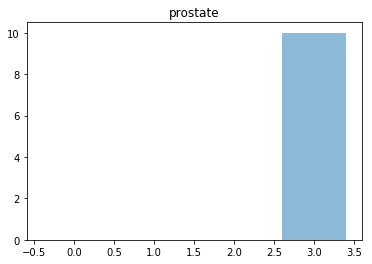

In [129]:
cancerHistogram(runKmeans(),cancerNames[0])